In [31]:
import numpy as np
import matplotlib.pylab as plt
import xarray as xr
import seaborn
import pandas as pd
from scipy.interpolate import griddata
import matplotlib
seaborn.set()
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelweight':'normal',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [32]:
#plt.rcParams.keys()

In [24]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [25]:
# Choose dimension e.g 'time'
dimension = 'elevation'

In [135]:
# Path to the DR0 and DR1 data-set
#FileName1 = '/data/isaac/DR0/Single_obsDR0/DR0Full2.zarr/'
#FileName2 = '/data/isaac/DR1/fullDR1.zarr'
FileName1 = '/data/isaac/DR0/verification/verifDR0.zarr'
FileName2 = '/data/isaac/DR1/verification/verifDR1.zarr'
# Loading the data
MyData1 = xr.open_zarr(FileName1)
MyData2 = xr.open_zarr(FileName2)
# Combining two dataset
data = MyData1+MyData2
# Extracting the Master and the Counter array
MyMaster = data.master.astype(float)
MyCounter =data.counter.astype(float)

In [136]:
# Load MeerKAT baseline
bl_len = pd.read_csv('/data/isaac/DR1/meerkatbaselinelengh.csv')
bl_len = bl_len.iloc[:,1:].values[0]
# Baseline index sorted by ascending order
indx = np.argsort(bl_len)

In [218]:
ii= np.where((freqValues>=1089)&(freqValues<=1091))[0]

In [219]:
freqValues = data.frequency.frequency.values/1e6

In [254]:
def Plot(data,startFreq,endFreq,time,clean=False):
    plt.clf()
    import matplotlib.style
    plt.style.use('classic')
    MyMaster = data.master.astype(float)
    MyCounter =data.counter.astype(float)
    freqValues = data.frequency.frequency.values/1e6
    if clean:
        l33 = np.where(((freqValues>=1375)&(freqValues<=1385)))[0]
        h1 = np.where(((freqValues>=1419)&(freqValues<=1421)))[0]
        l3 = np.append(l33,h1)
        idx1 = np.where(((freqValues>=1310)&(freqValues<=1490)))[0]
        idx2 = np.where(((freqValues>=970)&(freqValues<=1080)))[0]
        ind = np.append(idx2,idx1)
        notl3 = []
        for value in ind:
            if value not in l3:
                notl3.append(value)
        a = MyCounter.isel(time=i,frequency=notl3).sum(dim=['frequency','baseline'])
        b = MyMaster.isel(time=i,frequency=notl3).sum(dim=['frequency','baseline'])
        ElAzProb = b/a
    else:
        ii = np.where((freqValues>=startFreq)&(freqValues<=endFreq))[0]
        a = MyCounter.isel(time=i,frequency=slice(ii[0],ii[-1])).sum(dim=['frequency','baseline'])
        b = MyMaster.isel(time=i,frequency=slice(ii[0],ii[-1])).sum(dim=['frequency','baseline'])
        ElAzProb = b/a
    
    theta = np.deg2rad(np.arange(0,370,15))
    r = 80.-data.elevation.values 

    Mydata = ElAzProb.values

    MyNewData = np.concatenate((Mydata, Mydata[:,0,None]), axis=1)
    ax = plt.subplot(projection="polar")
    #print(ax)
    cmap = ax.pcolormesh(-theta,r,MyNewData,alpha = 0.75, shading='gouraud',vmin=0,vmax=1)
    ax.set_yticklabels(np.arange(80,10,-10))

    OwnLabel = [0,315,270,225,180,135,90,45]
    ax.set_xticklabels(OwnLabel)
    ax.set_theta_zero_location('N')
    ax.plot(0,0,'ro')
    plt.colorbar(cmap)
    #Chunk%04i"%(Segment)
    OutFile = "CleanBand-Time%02i"%(time)
    plt.title(OutFile)
    plt.savefig(OutFile)
    #return MyNewData,theta,r

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeW

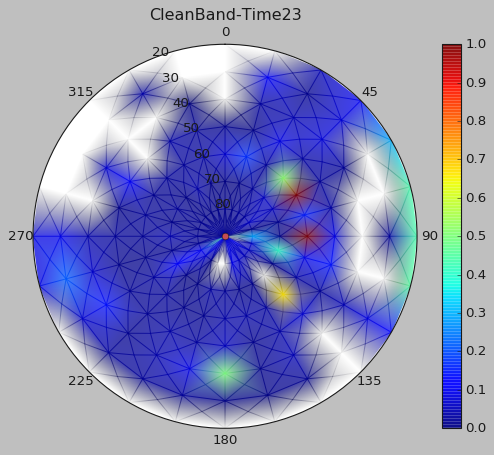

In [255]:
for i in range(24):
    Plot(data,1089,1091,i,clean=True)   

In [28]:
def mean(MyMaster,MyCounter):
    '''
    Takes the master and counter as well as dimension u are
    interested in.
    
    Returns : Probability array for the dimension u chose. 
    '''
    dimension = ['time','frequency','baseline','elevation','azimuth']
    ave = []
    for dim in dimension:
        if dim == 'time':
            print('time')
            MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','baseline','elevation','azimuth']) 
            MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','baseline','elevation','azimuth'])
            MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
            MyMeanTimeProb = MyMeanTimeProb.persist()
            ave.append(MyMeanTimeProb)
        if dim == 'frequency':
            print('frequency')
            MyMeanTimeMaster = MyMaster.sum(dim = ['time','baseline','elevation','azimuth']) 
            MyMeanTimeCounter = MyCounter.sum(dim = ['time','baseline','elevation','azimuth'])
            MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
            MyMeanTimeProb = MyMeanTimeProb.persist()
            ave.append(MyMeanTimeProb)
        if dim =='elevation':
            print('elvation')
            MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','baseline','time','azimuth']) 
            MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','baseline','time','azimuth'])
            MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
            MyMeanTimeProb = MyMeanTimeProb.persist()
            ave.append(MyMeanTimeProb)
        if dim =='baseline':
            print('baseline')
            MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','time','elevation','azimuth']) 
            MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','time','elevation','azimuth'])
            MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
            MyMeanTimeProb = MyMeanTimeProb.persist()
            ave.append(MyMeanTimeProb)
        if dim == 'azimuth':
            print('azimuth')
            MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','baseline','elevation','time']) 
            MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','baseline','elevation','time'])
            MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
            MyMeanTimeProb = MyMeanTimeProb.persist()
            ave.append(MyMeanTimeProb)
    return ave

In [ ]:
ave = mean(MyMaster,MyCounter) 

time
frequency
baseline


In [4]:
# Load the 1-D data for each file 
dim = ['time','frequency','baseline','elevation','azimuth']
arr = []
for dimension in dim:
    if dimension =='time':
        t0 = np.load('/data/isaac/DR0/one_D_Arrays/time_mean_R0.npy')
        t1 = np.load('/data/isaac/DR1/one_D_Arrays/Time_DR1_ave.npy')
        t1_del = np.delete(t1,24,0)
        t1_del = t1_del.tolist()
        # Combine dr0 and dr1 dataset
        for i in range(t0.shape[0]):
            t1_del.append(t0[i,:])
        arr.append(np.array(t1_del))
    if dimension =='frequency':
        t0 = np.load('/data/isaac/DR0/one_D_Arrays/Frequency_mean_R0.npy')
        t1 = np.load('/data/isaac/DR1/one_D_Arrays/Frequency_DR1_ave.npy')
        t1_del = np.delete(t1,24,0)
        t1_del = t1_del.tolist()
        # Combine dr0 and dr1 dataset
        for i in range(t0.shape[0]):
            t1_del.append(t0[i,:])
        arr.append(np.array(t1_del))
    if dimension =='baseline':
        t0 = np.load('/data/isaac/DR0/one_D_Arrays/Baseline_mean_R0.npy')
        t1 = np.load('/data/isaac/DR1/one_D_Arrays/Baseline_DR1_ave.npy')
        t1_del = np.delete(t1,24,0)
        t1_del = t1_del.tolist()
        # Combine dr0 and dr1 dataset
        for i in range(t0.shape[0]):
            t1_del.append(t0[i,:])
        arr.append(np.array(t1_del))
    if dimension =='elevation':
        t0 = np.load('/data/isaac/DR0/one_D_Arrays/Elevation_mean_R0.npy')
        t1 = np.load('/data/isaac/DR1/one_D_Arrays/Elevation_DR1_ave.npy')
        t1_del = np.delete(t1,24,0)
        t1_del = t1_del.tolist()
        # Combine dr0 and dr1 dataset
        for i in range(t0.shape[0]):
            t1_del.append(t0[i,:])
        arr.append(np.array(t1_del))
    if dimension=='azimuth':
        t0 = np.load('/data/isaac/DR0/one_D_Arrays/Azimuth_mean_R0.npy')
        t1 = np.load('/data/isaac/DR1/one_D_Arrays/Azimuth_DR1_ave.npy')
        t1_del = np.delete(t1,24,0)
        t1_del = t1_del.tolist()
        # Combine dr0 and dr1 dataset
        for i in range(t0.shape[0]):
            t1_del.append(t0[i,:])
        arr.append(np.array(t1_del))
        

In [19]:
def err(arr,ave,conf):
    arr = np.array(arr)
    lower = (100-conf)/2.0
    upper = 100 - lower
    l = np.zeros(arr.shape[1])
    u = np.zeros(arr.shape[1])
    med =  np.zeros(arr.shape[1])
   
    for i in range(arr.shape[1]):
        idx = np.where(~np.isnan(arr[:,i])&(arr[:,i]!=0))[0]
        if np.sum(idx)==0:
             data = np.sort(arr[:,i])
        else:
            data = np.sort(arr[:,i][idx])
        l[i] = np.percentile(data,lower)
        u[i] =  np.percentile(data,upper)
        med[i] = np.nanmedian(data)
    return l,u,med

In [20]:
er95 = err(arr[0],ave[0],conf=95)
er68 =  err(arr[0],ave[0],conf=68)

NameError: name 'ave' is not defined

In [82]:
#time = er95[2]

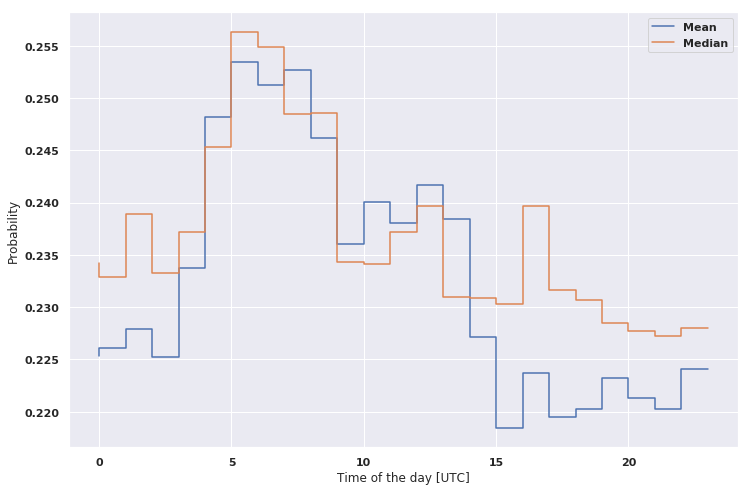

In [602]:
plt.figure(figsize=(12,8))
plt.step(np.arange(ave[0].shape[0]),ave[0],label='Mean'),#er[0],er[1],label='data',color='red')
#plt.step(np.arange(ave[0].shape[0]),er95[2],label='Median')
plt.fill_between(np.arange(ave[0].shape[0]), er95[0], er95[1],
                 color='gray', alpha=0.2,label='95 Percentile Confidence Interval')
plt.fill_between(np.arange(ave[0].shape[0]), er68[0], er68[1],
                 color='r', alpha=0.4,label='68 Percentile Confidence Interval')
plt.xlabel('Time of the day [UTC]')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [603]:
er95 = err(arr[1],ave[1],conf=95)
er68 =  err(arr[1],ave[1],conf=68)

In [604]:
frq = er95[2]

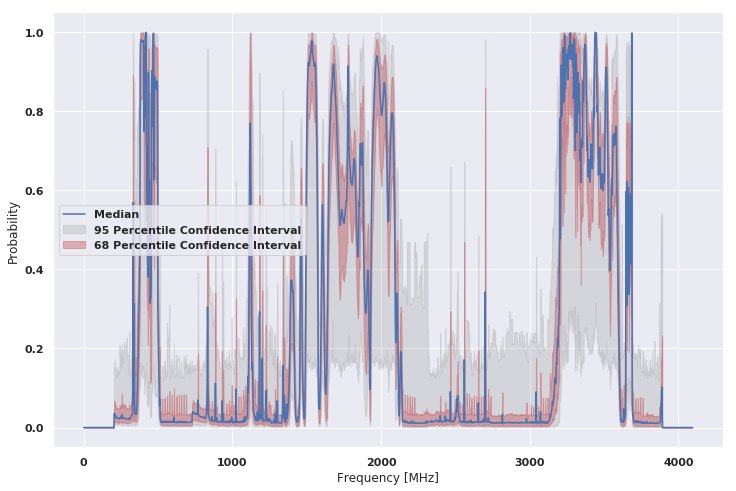

In [605]:
plt.figure(figsize=(12,8))
#plt.plot(np.arange(ave[1].shape[0]),ave[1],label='Mean')
plt.plot(np.arange(ave[1].shape[0]),er95[2],label='Median')
plt.fill_between(np.arange(ave[1].shape[0]), er95[0], er95[1],
                 color='gray', alpha=0.2,label='95 Percentile Confidence Interval')
plt.fill_between(np.arange(ave[1].shape[0]), er68[0], er68[1],
                 color='r', alpha=0.4,label='68 Percentile Confidence Interval')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [30]:
freq = data.frequency.values/1e6 

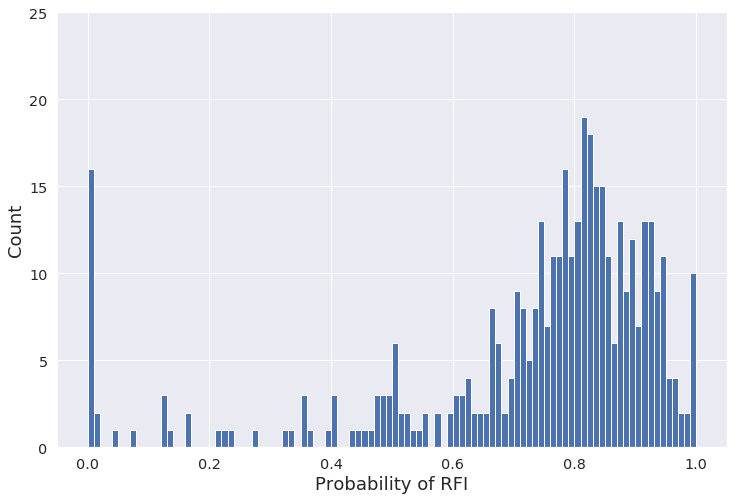

In [8]:
plt.figure(figsize=(12,8))
plt.hist(arr[1][:,2000],bins=100)
plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

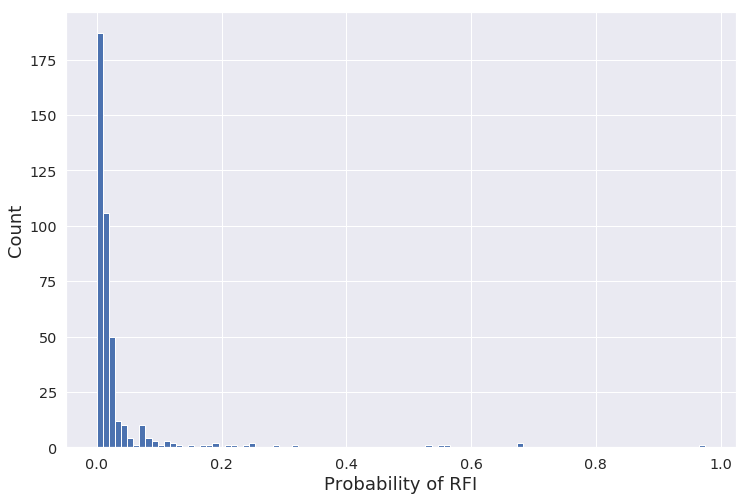

In [9]:
plt.figure(figsize=(12,8))
plt.hist(arr[1][:,2900],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

In [263]:
er95 = err(arr[2],ave[2],conf=95)
er68 =  err(arr[2],ave[2],conf=68)

In [264]:
bln = er95[2]

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/xarray/core/indexing.py:1195: PerformanceWarning: Slicing with an out-of-order index is generating 204 times more chunks
  return self.array[key]


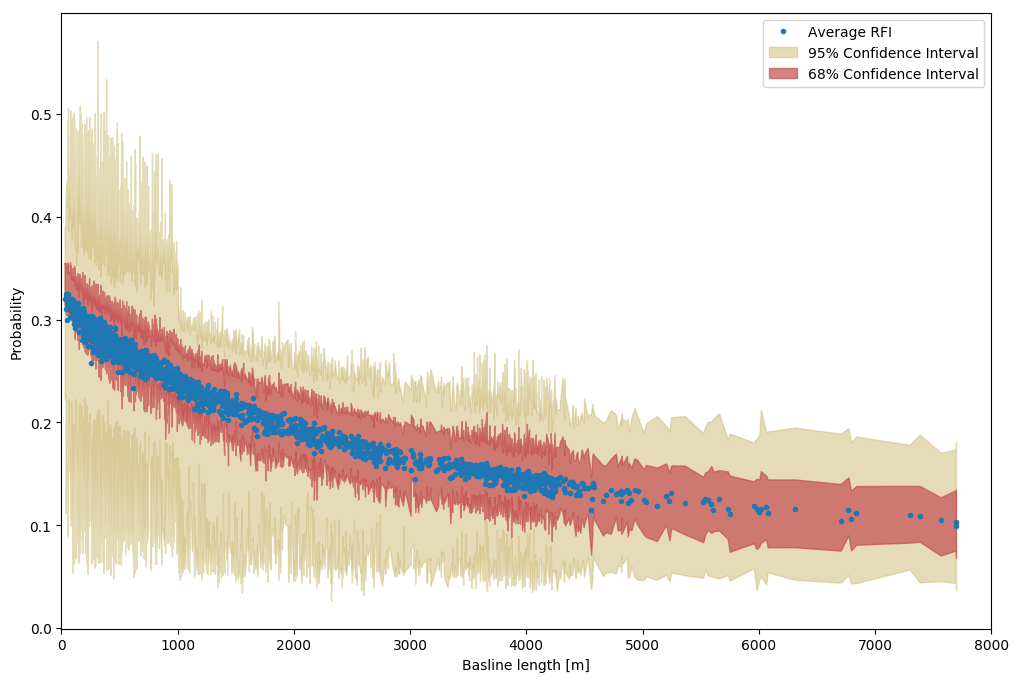

In [270]:
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.plot(bl_len[indx],ave[2][indx],'.',label='Average RFI')
#plt.plot(bl_len[indx],er95[2][indx],'.',label='Mean')
plt.fill_between(bl_len[indx], er95[0][indx], er95[1][indx],
                 color='y', alpha=0.5,label='95% Confidence Interval')
plt.fill_between(bl_len[indx], er68[0][indx], er68[1][indx],
                 color='r', alpha=0.7,label='68% Confidence Interval')
plt.xlim(0.0,8000)
plt.xlabel('Basline length [m]')
plt.ylabel('Probability')
plt.legend()
plt.show()

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/isihlangu/hprfi/local/lib/python3.5/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


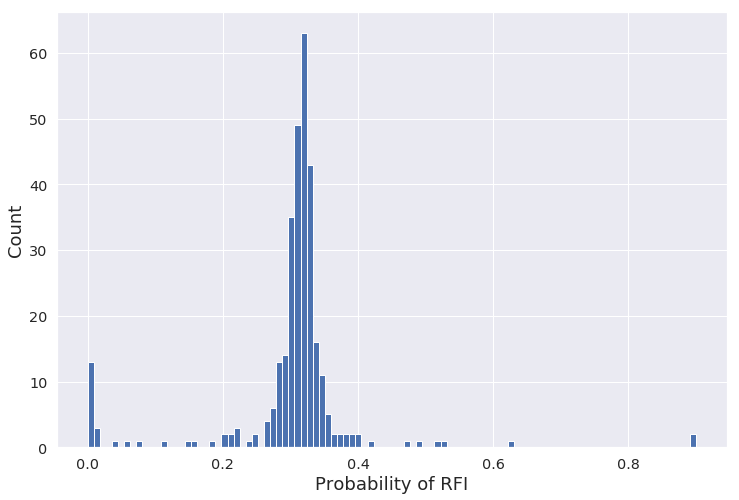

In [12]:
plt.figure(figsize=(12,8))
plt.hist(arr[2][:,indx][:,100],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

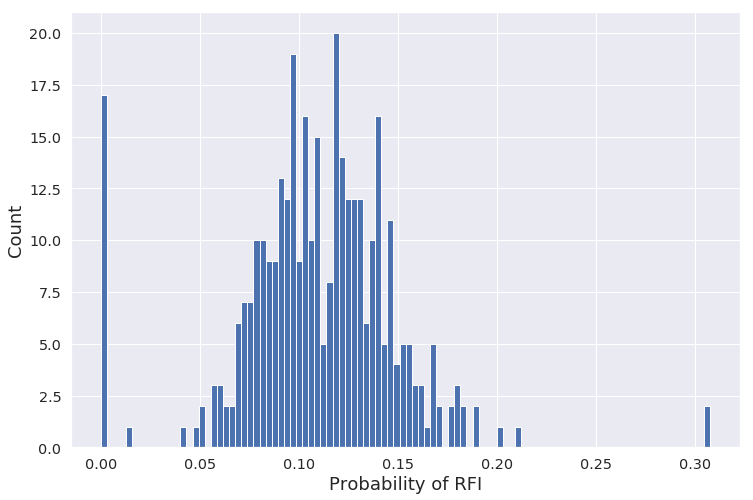

In [13]:
plt.figure(figsize=(12,8))
plt.hist(arr[2][:,indx][:,2000],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

In [613]:
er95 = err(arr[3],ave[3],conf=95)
er68 =  err(arr[3],ave[3],conf=68)

In [614]:
elv = er95[2]

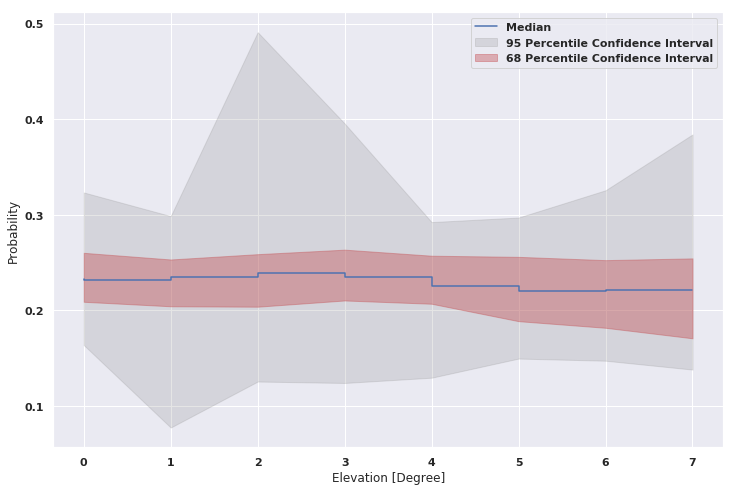

In [615]:

plt.figure(figsize=(12,8))
#plt.step(np.arange(ave[3].shape[0]),ave[3],label='Mean')
plt.step(np.arange(ave[3].shape[0]),er95[2],label='Median')
plt.fill_between(np.arange(ave[3].shape[0]), er95[0], er95[1],
                 color='gray', alpha=0.2,label='95 Percentile Confidence Interval')
plt.fill_between(np.arange(ave[3].shape[0]), er68[0], er68[1],
                 color='r', alpha=0.4,label='68 Percentile Confidence Interval')
plt.xlabel('Elevation [Degree]')
plt.ylabel('Probability')
plt.legend()
plt.show()

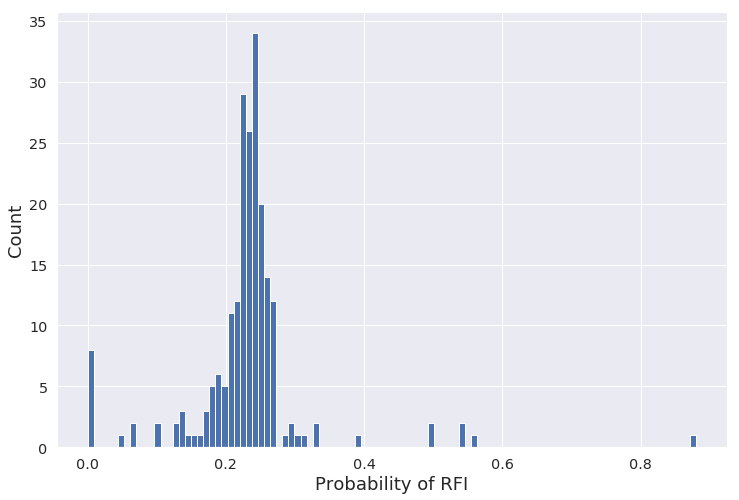

In [15]:
plt.figure(figsize=(12,8))
plt.hist(arr[3][:,2],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

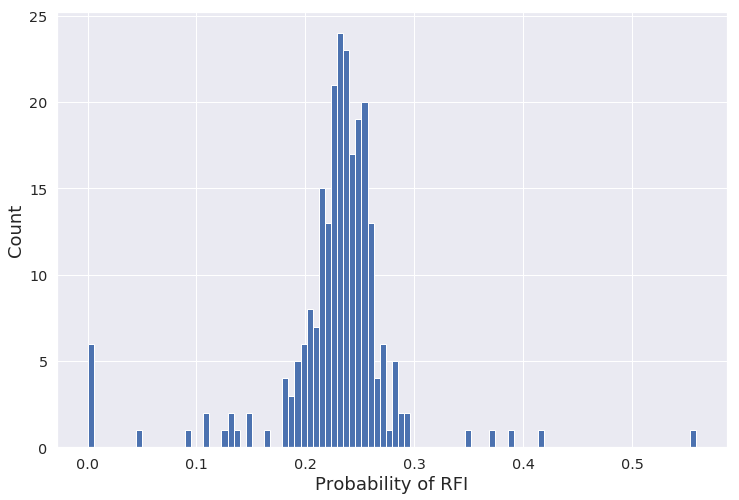

In [16]:
plt.figure(figsize=(12,8))
plt.hist(arr[3][:,4],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

In [616]:
er95 = err(arr[4],ave[4],conf=95)
er68 =  err(arr[4],ave[4],conf=68)

In [617]:
az = er95[2]

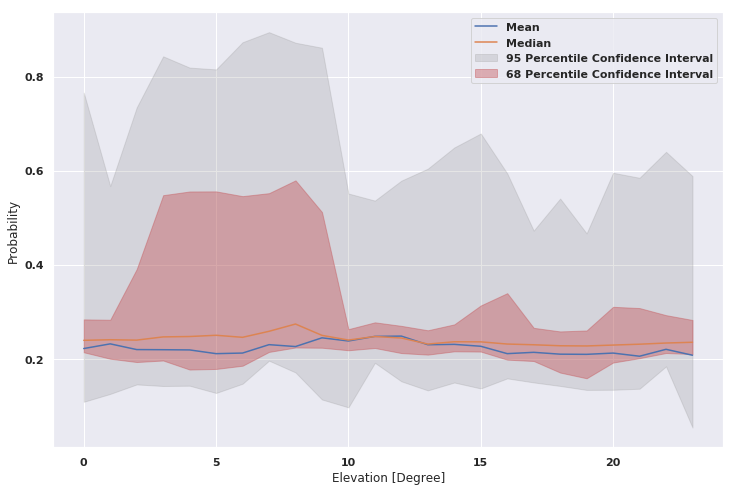

In [599]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(ave[4].shape[0]),ave[4],label='Mean')
plt.plot(np.arange(ave[4].shape[0]),er95[2],label='Median')
plt.fill_between(np.arange(ave[4].shape[0]), er95[0], er95[1],
                 color='gray', alpha=0.2,label='95 Percentile Confidence Interval')
plt.fill_between(np.arange(ave[4].shape[0]), er68[0], er68[1],
                 color='r', alpha=0.4,label='68 Percentile Confidence Interval')
plt.xlabel('Elevation [Degree]')
plt.xlabel('Elevation [Degree]')
plt.ylabel('Probability')
plt.legend()
plt.show()

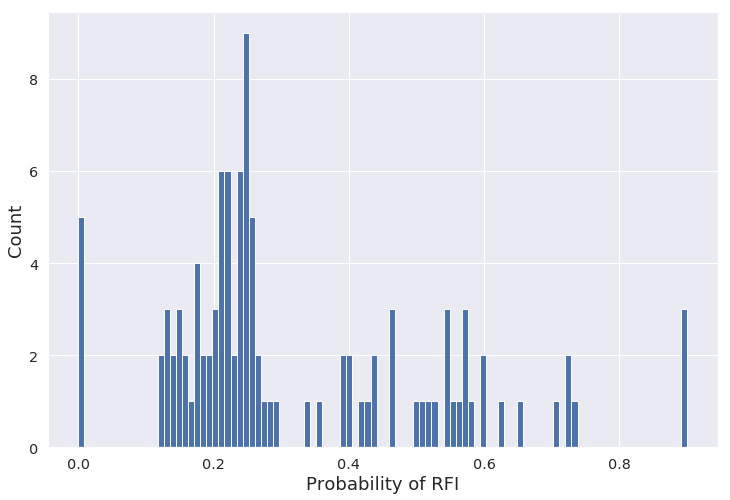

In [17]:
plt.figure(figsize=(12,8))
plt.hist(arr[4][:,5],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()

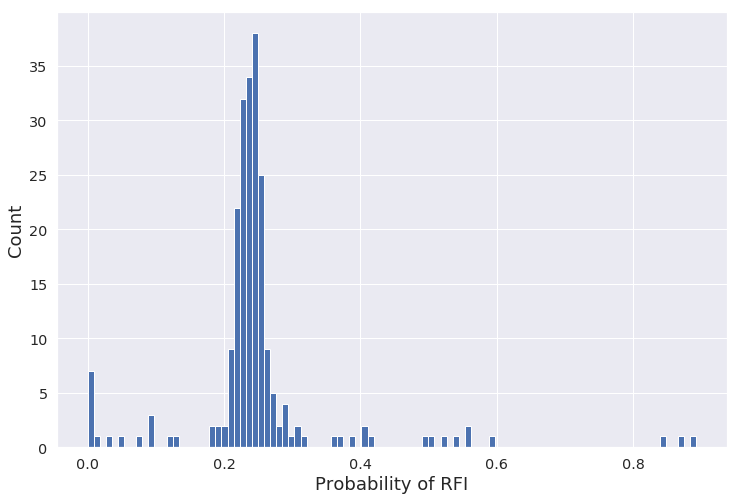

In [18]:
plt.figure(figsize=(12,8))
plt.hist(arr[4][:,10],bins=100)
#plt.ylim(0,25)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Probability of RFI',fontsize = 18)
plt.show()